In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# 使用ONNX模型从提示点中生成遮罩。
# *Produces masks from prompts using an ONNX model*

SAM的提示编码器和掩码解码器是非常轻量级的，这使得在给定用户输入时可以有效地计算遮罩。这个例子展示了一个例子，说明如何以ONNX格式导出和使用模型的这个轻量级组件，使其能够在支持ONNX runtime的各种平台上运行。  
原文：  
*SAM's prompt encoder and mask decoder are very lightweight, which allows for efficient computation of a mask given user input. This notebook shows an example of how to export and use this lightweight component of the model in ONNX format, allowing it to run on a variety of platforms that support an ONNX runtime.*

## 环境设置
## *Environment Set-up*

请注意，这个示例笔记本需要onnx和onnxruntime两个可选依赖项，此外还有用于可视化的opencv-python和matplotlib。  
原文：  
*Note that this notebook requires both the `onnx` and `onnxruntime` optional dependencies, in addition to `opencv-python` and `matplotlib` for visualization.*

In [2]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.utils.onnx import SamOnnxModel

import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic

In [1]:
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

## 导出一个ONNX模型
## *Export an ONNX model*

将下面的路径设置为一个SAM模型检查点，然后加载模型。这对于导出模型和计算模型的嵌入都是需要的。  
*Set the path below to a SAM model checkpoint, then load the model. This will be needed to both export the model and to calculate embeddings for the model.*

In [9]:
sam_checkpoint = r"D:\download\sam_vit_l_0b3195.pth"
model_type = "vit_l"

In [10]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

脚本 segment-anything/scripts/export_onnx_model.py 可用于导出 SAM 的必要部分。或者，运行下面的代码来导出一个ONNX模型。如果你已经导出了一个模型，请设置下面的路径并跳到下一节。保证导出的ONNX模型与上面设置的检查点和模型类型一致。本笔记本希望在导出模型时使用 return_single_mask=True 参数。  
原文：  
*The script `segment-anything/scripts/export_onnx_model.py` can be used to export the necessary portion of SAM. Alternatively, run the following code to export an ONNX model. If you have already exported a model, set the path below and skip to the next section. Assure that the exported ONNX model aligns with the checkpoint and model type set above. This notebook expects the model was exported with the parameter `return_single_mask=True`.*

In [ ]:
onnx_model_path = None  # Set to use an already exported model, then skip to the next section.

In [7]:
import warnings

onnx_model_path = "sam_vit_l_0b3195.onnx"

onnx_model = SamOnnxModel(sam, return_single_mask=True)

dynamic_axes = {
    "point_coords": {1: "num_points"},
    "point_labels": {1: "num_points"},
}

embed_dim = sam.prompt_encoder.embed_dim
embed_size = sam.prompt_encoder.image_embedding_size
mask_input_size = [4 * x for x in embed_size]
dummy_inputs = {
    "image_embeddings": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
    "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
    "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
    "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
    "has_mask_input": torch.tensor([1], dtype=torch.float),
    "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
}
output_names = ["masks", "iou_predictions", "low_res_masks"]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    with open(onnx_model_path, "wb") as f:
        torch.onnx.export(
            onnx_model,
            tuple(dummy_inputs.values()),
            f,
            export_params=True,
            verbose=False,
            opset_version=17,
            do_constant_folding=True,
            input_names=list(dummy_inputs.keys()),
            output_names=output_names,
            dynamic_axes=dynamic_axes,
        )    

============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



如果需要，该模型还可以被量化和优化。我们发现这样做可以大大改善网络运行时间，而质量性能的变化可以忽略不计。运行下一个单元来量化模型，否则跳到下一节。  
原文：  
*If desired, the model can additionally be quantized and optimized. We find this improves web runtime significantly for negligible change in qualitative performance. Run the next cell to quantize the model, or skip to the next section otherwise.*

In [8]:
onnx_model_quantized_path = "sam_vit_l_0b3195.onnx"
quantize_dynamic(
    model_input=onnx_model_path,
    model_output=onnx_model_quantized_path,
    optimize_model=True,
    per_channel=False,
    reduce_range=False,
    weight_type=QuantType.QUInt8,
)
onnx_model_path = onnx_model_quantized_path

Ignore MatMul due to non constant B: /[/transformer/layers.0/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_token_to_image/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_token_to_image/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_image_to_token/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_image_to_token/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.1/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_token_to_image/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_token_to_image/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_image_to_token/MatMul]
Ignore Ma

## 示例图片
## *Example Image*

In [3]:
image = cv2.imread('images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## 使用ONNX模型
## *Using an ONNX model*

这里有一个例子，在CPU上使用python的onnxruntime来执行ONNX模型。然而，原则上可以使用任何支持ONNX运行时的平台。启动下面的运行时会话：  
原文：  
*Here as an example, we use `onnxruntime` in python on CPU to execute the ONNX model. However, any platform that supports an ONNX runtime could be used in principle. Launch the runtime session below:*

In [5]:
onnx_model_path = "sam_vit_l_0b3195.onnx"

In [6]:
# ort_session = onnxruntime.InferenceSession(onnx_model_path)
ort_session = onnxruntime.InferenceSession(onnx_model_path,providers=['CUDAExecutionProvider'])  # CUDAExecutionProvider、CPUExecutionProvider

为了使用ONNX模型，图像必须首先使用SAM图像编码器进行预处理。这是一个较重的过程，最好在GPU上执行。SamPredictor可以正常使用，然后.get_image_embedding()将检索出中间特征。  
原文：  
*To use the ONNX model, the image must first be pre-processed using the SAM image encoder. This is a heavier weight process best performed on GPU. SamPredictor can be used as normal, then `.get_image_embedding()` will retreive the intermediate features.*

In [11]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.utils.onnx import SamOnnxModel

sam.to(device='cuda')
predictor = SamPredictor(sam)

In [12]:
predictor.set_image(image)

In [13]:
image_embedding = predictor.get_image_embedding().cpu().numpy()

In [14]:
image_embedding.shape

(1, 256, 64, 64)

ONNX模型的输入签名与SamPredictor.predict不同。以下输入必须全部提供。注意点和遮罩输入的特殊情况。所有输入都是np.float32。

* `image_embeddings`: 来自predictor.get_image_embedding()的图像嵌入。有一个长度为1的批次索引。
* `point_coords`: 稀疏输入提示的坐标，对应于点输入和盒输入。盒子使用两个点进行编码，一个用于左上角，一个用于右下角。坐标必须已经被转换为长边1024。有一个长度为1的批次索引。
* `point_labels`: 稀疏输入提示的标签。0是负的输入点，1是正的输入点，2是左上角的盒角，3是右下角的盒角，-1是一个填充点。如果没有框内输入，应该连接一个标签为-1、坐标为（0.0, 0.0）的填充点。
* `mask_input`: 形状为1x1x256x256的模型的掩码输入。即使没有掩码输入，也必须提供这个。在这种情况下，它可以只是零。
* `has_mask_input`: 掩码输入的一个指标。1表示有掩码输入，0表示没有掩码输入。
* `orig_im_size`: 输入图像的尺寸，以(H,W)格式，在任何转换之前。  
此外，ONNX模型不对输出的掩码对数进行阈值处理。要获得二进制掩码，请在sam.mask_threshold（等于0.0）处设置阈值。  

原文：  
The ONNX model has a different input signature than `SamPredictor.predict`. The following inputs must all be supplied. Note the special cases for both point and mask inputs. All inputs are `np.float32`.
* `image_embeddings`: The image embedding from `predictor.get_image_embedding()`. Has a batch index of length 1.
* `point_coords`: Coordinates of sparse input prompts, corresponding to both point inputs and box inputs. Boxes are encoded using two points, one for the top-left corner and one for the bottom-right corner. *Coordinates must already be transformed to long-side 1024.* Has a batch index of length 1.
* `point_labels`: Labels for the sparse input prompts. 0 is a negative input point, 1 is a positive input point, 2 is a top-left box corner, 3 is a bottom-right box corner, and -1 is a padding point. *If there is no box input, a single padding point with label -1 and coordinates (0.0, 0.0) should be concatenated.*
* `mask_input`: A mask input to the model with shape 1x1x256x256. This must be supplied even if there is no mask input. In this case, it can just be zeros.
* `has_mask_input`: An indicator for the mask input. 1 indicates a mask input, 0 indicates no mask input.
* `orig_im_size`: The size of the input image in (H,W) format, before any transformation. 

Additionally, the ONNX model does not threshold the output mask logits. To obtain a binary mask, threshold at `sam.mask_threshold` (equal to 0.0).

### Example point input

In [15]:
input_point = np.array([[500, 375]])
input_label = np.array([1])

NameError: name 'np' is not defined

添加一个批处理索引，串联一个填充点，并进行转换。  
原文：  
*Add a batch index, concatenate a padding point, and transform.*

In [18]:
onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)

onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)


创建一个空的掩码输入和一个无掩码的指标。  
原文：  
*Create an empty mask input and an indicator for no mask.*

In [19]:
onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

将输入打包到onnx模型中运行  
原文：  
*Package the inputs to run in the onnx model*

In [20]:
ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

预测一个遮罩并且设置一个阈值。  
*Predict a mask and threshold it.*

In [26]:
masks, _, low_res_logits = ort_session.run(None, ort_inputs)
masks = masks > predictor.model.mask_threshold

In [27]:
masks.shape

(1, 1, 1200, 1800)

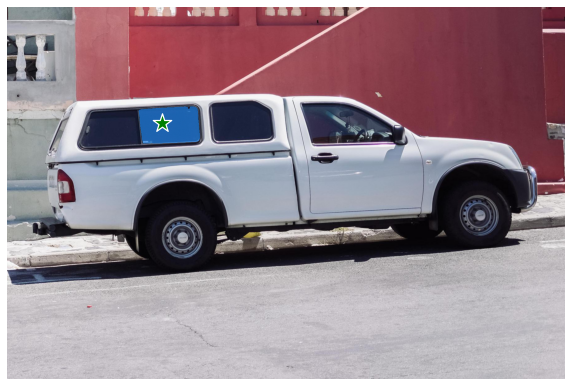

In [29]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

### 遮罩输入示例
### *Example mask input*

In [30]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 1])

# 使用前一次运行的掩码输出。它已经以正确的形式输入到ONNX模型。
# Use the mask output from the previous run. It is already in the correct form for input to the ONNX model.
onnx_mask_input = low_res_logits

像前面的例子一样，对各点进行变换。  
原文：  
*Transform the points as in the previous example.*

In [31]:
onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)

onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)

has_mask_input指标现在是1。  
*The `has_mask_input` indicator is now 1.*

In [32]:
onnx_has_mask_input = np.ones(1, dtype=np.float32)

封装输入，然后预测和阈值的遮罩。  
*Package inputs, then predict and threshold the mask.*

In [33]:
ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

masks, _, _ = ort_session.run(None, ort_inputs)
masks = masks > predictor.model.mask_threshold

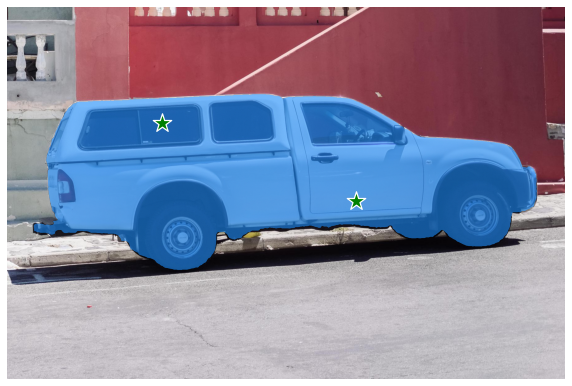

In [34]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

### 框和点的输入示例
### *Example box and point input*

In [35]:
input_box = np.array([425, 600, 700, 875])
input_point = np.array([[575, 750]])
input_label = np.array([0])

添加一个批处理索引，串联一个框和点的输入，为框的角添加适当的标签，然后进行转换。没有填充点，因为输入包括一个框的输入。  
原文：  
*Add a batch index, concatenate a box and point inputs, add the appropriate labels for the box corners, and transform. There is no padding point since the input includes a box input.*

In [36]:
onnx_box_coords = input_box.reshape(2, 2)
onnx_box_labels = np.array([2,3])

onnx_coord = np.concatenate([input_point, onnx_box_coords], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, onnx_box_labels], axis=0)[None, :].astype(np.float32)

onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)

封装输入，然后预测和阈值的遮罩。  
*Package inputs, then predict and threshold the mask.*

In [37]:
onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

masks, _, _ = ort_session.run(None, ort_inputs)
masks = masks > predictor.model.mask_threshold

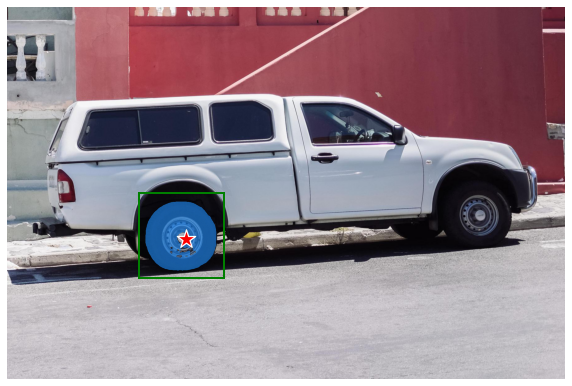

In [38]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()